# 05. Scrapy를 사용해서 스크레이핑하기

## Scrapy
- 크롤러 개발을 위한 프레임워크
- 시작이 되는 인덱스를 설정하고, '어떠한 규칙에 따라 스크레이핑하고, 어떠한 모델에 맞게 데이터를 추출하고, 출력한다'라는 방법만 규칙에 따라 적으면 자동으로 크롤링
- 내부적으로 병렬 다운로드 등을 지원하므로 크롤러의 세부적인 내부 구현을 하지 않아도 됨
- w3lib : 서브 프로젝트 중 하나로 HTML 태그 제거와 URL 인코드 등을 간편하게 해주는 유틸리티
- Item : 여러 개의 항목을 모아 놓은 모델
- Spider : 크롤러 프로그램 본체를 의미(봇)

### Scrapy 설치 및 프로젝트 생성
- `pip install scrapy`
- `scrapy startproject my_project`
- `cd myproject`

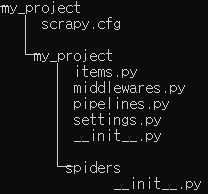

### Item 정의하기
- Quotes to Scrape 사이트를 대상으로 연습(http://quotes.toscrape.com/)
- `my_project/my_project/items.py`
    - 수집하고 싶은 값을 `name = scrapy.Field()` 형태로 작성

```python
import scrapy

class Quote(scrapy.Item):
    """격언 아이템"""
    author = scrapy.Field()
    text = scrapy.Field()
    tags = scrapy.Field()
```

### Spider 만들기
- Spider 생성 전용 명령어를 사용
    - 명령어를 사용하지 않고도 만들 수 있지만, 명령어를 사용하면 기본적인 형태의 코드가 작성된 파일이 생성되므로 이를 참고하여 코드를 작성할 수 있게 됨
- `scrapy genspider -t crawl quotes quotes.toscrape.com`를 실행하면 `my_projcet/my_project/spider/quotes.py` 생성
    - `-t` : 템플릿을 지정하는 옵션
        - `crawl` : 웹 사이트 크롤링 전용
        - `xmlfeed` : XML 피드 크롤링 전용
        - `csvfeed` : CSV 피드 크롤링 전용
    - `quotes` : Spider 파일 이름
    
- `my_project/my_project/spider/quotes.py` 최초 생성시

```python
import scrapy
from scrapy.linkextractors import LinkExtractor
from scrapy.spiders import CrawlSpider, Rule


class QuotesSpider(CrawlSpider):
    name = 'quotes'
    allowed_domains = ['quotes.toscrape.com']
    start_urls = ['http://quotes.toscrape.com/']

    rules = (
        Rule(LinkExtractor(allow=r'Items/'), callback='parse_item', follow=True),
    )

    def parse_item(self, response):
        item = {}
        #item['domain_id'] = response.xpath('//input[@id="sid"]/@value').get()
        #item['name'] = response.xpath('//div[@id="name"]').get()
        #item['description'] = response.xpath('//div[@id="description"]').get()
        return item

```

- `my_project/my_project/spider/quotes-1.py` 입맛에 맛게 수정 후
    - `name` : 크롤러를 실행할 때에 지정할 크롤러 이름 설정
    - `allowed_domains` : 크롤링 대상 콘텐츠의 도메인을 제한
    - `start_urls` : 크롤링 시작 지점이 되는 인덱스 페이지의 URL 설정
    - 인덱스 페이지의 HTML 소스는 `parse` 메서드의 `response`에 `scrapy.http.response.html.HtmlResponse` 클래스 객체로 전달되며 `response.body`와 `response.text` 형태로 내부의 내용을 참조할 수 있음
    - `response.css()` 메서드 대신 `response.xpath()` 메서드를 사용해도 되지만 주의해야할 점이 있음
        - `css` 메서드는 하나의 객체를 대상으로 스크레이핑 하지만 `xpath` 메서드는 선택한 객체를 스크레이핑하는 것이 아닌 XPath로 지정한 부모의 DOM 계층에서 스크레이핑이 일어나 사용하다 보면 예상하지 못한 결과가 나오는 경우도 있음
    - 스크레이핑 전용 메서드로 추출한 결과는 `scrapy.selector.unified.SelectorList` 클래스 객체로 반환되며 이 객체에 추가로 `xpath`나 `css` 메서드를 적용할 수 있음
    - `getall` 메서드 : 스크레이핑 조건에 맞는 객체들을 반환 (extract_first에서 바뀜)
    - `get` 메서드 : 스크레이핑 조건에 맞는 처음 객체만 반환 (extract에서 바뀜)
    - `yield item` 대신 items 리스트에 모든 item을 넣은 후 `return items`를 해도 같은 결과가 나옴

```python
import scrapy
from scrapy.spiders import CrawlSpider

from my_project.items import Quote

class QuotesSpider(CrawlSpider):
    """Quote 아이템을 수집하는 크롤러"""
    
    name = 'quotes-1'
    allowed_domains = ['quotes.toscrape.com']
    
    def start_requests(self):
        urls = [
            'http://quotes.toscrape.com/'
        ]

        return [scrapy.Request(url=url, callback=self.parse) for url in urls]
        """또는
        for url in urls:
            yield scrapy.Request(url=url, callback=self.parse)
        """

    def parse(self, response):
        """크롤링한 페이지에서 Item을 스크레이핑"""
        for quote_html in response.css('div.quote'):
            item = Quote()
            item['author'] = quote_html.css('small.author::text').get()
            item['text'] = quote_html.css('span.text::text').get()
            item['tags'] = quote_html.css('div.tags a.tag::text').getall()
            yield item
```

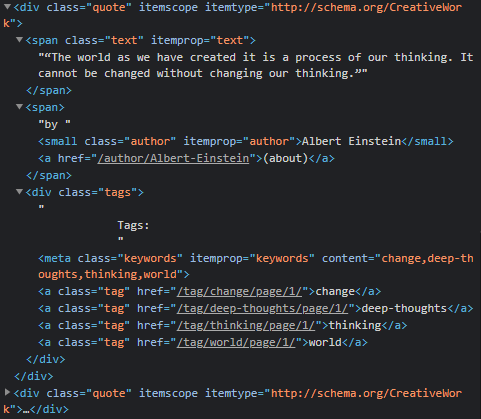

### 크롤러 실행하기
- `scrapy crawl quotes-1`

```
my_project>scrapy crawl quotes
2021-10-06 16:51:44 [scrapy.utils.log] INFO: Scrapy 2.5.1 started (bot: my_project)
2021-10-06 16:51:44 [scrapy.utils.log] INFO: Versions: lxml 4.6.3.0, libxml2 2.9.5, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 21.7.0, Python 3.7.6 | packaged by conda-forge | (default, Jun  1 2020, 18:11:50) [MSC v.1916 64 bit (AMD64)], pyOpenSSL 20.0.1 (OpenSSL 1.1.1k  25 Mar 2021), cryptography 3.4.7, Platform Windows-10-10.0.19041-SP0
2021-10-06 16:51:44 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.selectreactor.SelectReactor
2021-10-06 16:51:44 [scrapy.crawler] INFO: Overridden settings:
{'BOT_NAME': 'my_project',
 'NEWSPIDER_MODULE': 'my_project.spiders',
 'ROBOTSTXT_OBEY': True,
 'SPIDER_MODULES': ['my_project.spiders']}
2021-10-06 16:51:44 [scrapy.extensions.telnet] INFO: Telnet Password: af8b6f40d4ad75ab
2021-10-06 16:51:44 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.logstats.LogStats']
2021-10-06 16:51:44 [scrapy.middleware] INFO: Enabled downloader middlewares:
['scrapy.downloadermiddlewares.robotstxt.RobotsTxtMiddleware',
 'scrapy.downloadermiddlewares.httpauth.HttpAuthMiddleware',
 'scrapy.downloadermiddlewares.downloadtimeout.DownloadTimeoutMiddleware',
 'scrapy.downloadermiddlewares.defaultheaders.DefaultHeadersMiddleware',
 'scrapy.downloadermiddlewares.useragent.UserAgentMiddleware',
 'scrapy.downloadermiddlewares.retry.RetryMiddleware',
 'scrapy.downloadermiddlewares.redirect.MetaRefreshMiddleware',
 'scrapy.downloadermiddlewares.httpcompression.HttpCompressionMiddleware',
 'scrapy.downloadermiddlewares.redirect.RedirectMiddleware',
 'scrapy.downloadermiddlewares.cookies.CookiesMiddleware',
 'scrapy.downloadermiddlewares.httpproxy.HttpProxyMiddleware',
 'scrapy.downloadermiddlewares.stats.DownloaderStats']
2021-10-06 16:51:44 [scrapy.middleware] INFO: Enabled spider middlewares:
['scrapy.spidermiddlewares.httperror.HttpErrorMiddleware',
 'scrapy.spidermiddlewares.offsite.OffsiteMiddleware',
 'scrapy.spidermiddlewares.referer.RefererMiddleware',
 'scrapy.spidermiddlewares.urllength.UrlLengthMiddleware',
 'scrapy.spidermiddlewares.depth.DepthMiddleware']
2021-10-06 16:51:44 [scrapy.middleware] INFO: Enabled item pipelines:
[]
2021-10-06 16:51:44 [scrapy.core.engine] INFO: Spider opened
2021-10-06 16:51:44 [scrapy.extensions.logstats] INFO: Crawled 0 pages (at 0 pages/min), scraped 0 items (at 0 items/min)
2021-10-06 16:51:44 [scrapy.extensions.telnet] INFO: Telnet console listening on 127.0.0.1:6023
2021-10-06 16:51:44 [scrapy.core.engine] DEBUG: Crawled (404) <GET http://quotes.toscrape.com/robots.txt> (referer: None)
2021-10-06 16:51:44 [scrapy.core.engine] DEBUG: Crawled (200) <GET http://quotes.toscrape.com/> (referer: None)
2021-10-06 16:51:45 [scrapy.core.scraper] DEBUG: Scraped from <200 http://quotes.toscrape.com/>
{'author': 'Albert Einstein',
 'tags': ['change', 'deep-thoughts', 'thinking', 'world'],
 'text': '“The world as we have created it is a process of our thinking. It '
         'cannot be changed without changing our thinking.”'}
2021-10-06 16:51:45 [scrapy.core.scraper] DEBUG: Scraped from <200 http://quotes.toscrape.com/>
{'author': 'J.K. Rowling',
 'tags': ['abilities', 'choices'],
 'text': '“It is our choices, Harry, that show what we truly are, far more '
         'than our abilities.”'}
2021-10-06 16:51:45 [scrapy.core.scraper] DEBUG: Scraped from <200 http://quotes.toscrape.com/>
{'author': 'Albert Einstein',
 'tags': ['inspirational', 'life', 'live', 'miracle', 'miracles'],
 'text': '“There are only two ways to live your life. One is as though nothing '
         'is a miracle. The other is as though everything is a miracle.”'}
2021-10-06 16:51:45 [scrapy.core.scraper] DEBUG: Scraped from <200 http://quotes.toscrape.com/>
{'author': 'Jane Austen',
 'tags': ['aliteracy', 'books', 'classic', 'humor'],
 'text': '“The person, be it gentleman or lady, who has not pleasure in a good '
         'novel, must be intolerably stupid.”'}
2021-10-06 16:51:45 [scrapy.core.scraper] DEBUG: Scraped from <200 http://quotes.toscrape.com/>
{'author': 'Marilyn Monroe',
 'tags': ['be-yourself', 'inspirational'],
 'text': "“Imperfection is beauty, madness is genius and it's better to be "
         'absolutely ridiculous than absolutely boring.”'}
2021-10-06 16:51:45 [scrapy.core.scraper] DEBUG: Scraped from <200 http://quotes.toscrape.com/>
{'author': 'Albert Einstein',
 'tags': ['adulthood', 'success', 'value'],
 'text': '“Try not to become a man of success. Rather become a man of value.”'}
2021-10-06 16:51:45 [scrapy.core.scraper] DEBUG: Scraped from <200 http://quotes.toscrape.com/>
{'author': 'André Gide',
 'tags': ['life', 'love'],
 'text': '“It is better to be hated for what you are than to be loved for what '
         'you are not.”'}
2021-10-06 16:51:45 [scrapy.core.scraper] DEBUG: Scraped from <200 http://quotes.toscrape.com/>
{'author': 'Thomas A. Edison',
 'tags': ['edison', 'failure', 'inspirational', 'paraphrased'],
 'text': "“I have not failed. I've just found 10,000 ways that won't work.”"}
2021-10-06 16:51:45 [scrapy.core.scraper] DEBUG: Scraped from <200 http://quotes.toscrape.com/>
{'author': 'Eleanor Roosevelt',
 'tags': ['misattributed-eleanor-roosevelt'],
 'text': '“A woman is like a tea bag; you never know how strong it is until '
         "it's in hot water.”"}
2021-10-06 16:51:45 [scrapy.core.scraper] DEBUG: Scraped from <200 http://quotes.toscrape.com/>
{'author': 'Steve Martin',
 'tags': ['humor', 'obvious', 'simile'],
 'text': '“A day without sunshine is like, you know, night.”'}
2021-10-06 16:51:45 [scrapy.core.engine] INFO: Closing spider (finished)
2021-10-06 16:51:45 [scrapy.statscollectors] INFO: Dumping Scrapy stats:
{'downloader/request_bytes': 456,
 'downloader/request_count': 2,
 'downloader/request_method_count/GET': 2,
 'downloader/response_bytes': 2582,
 'downloader/response_count': 2,
 'downloader/response_status_count/200': 1,
 'downloader/response_status_count/404': 1,
 'elapsed_time_seconds': 0.626576,
 'finish_reason': 'finished',
 'finish_time': datetime.datetime(2021, 10, 6, 7, 51, 45, 31036),
 'httpcompression/response_bytes': 11053,
 'httpcompression/response_count': 1,
 'item_scraped_count': 10,
 'log_count/DEBUG': 12,
 'log_count/INFO': 10,
 'response_received_count': 2,
 'robotstxt/request_count': 1,
 'robotstxt/response_count': 1,
 'robotstxt/response_status_count/404': 1,
 'scheduler/dequeued': 1,
 'scheduler/dequeued/memory': 1,
 'scheduler/enqueued': 1,
 'scheduler/enqueued/memory': 1,
 'start_time': datetime.datetime(2021, 10, 6, 7, 51, 44, 404460)}
2021-10-06 16:51:45 [scrapy.core.engine] INFO: Spider closed (finished)
```

### 로그 확인하기(1)
- 로그 첫 부분 : Scrapy 설정 정보 INFO 로그
- `2021-10-06 16:51:44 [scrapy.core.engine] INFO: Spider opened` : Spider에 작성한 처리를 시작한다고 알림
- `2021-10-06 16:51:44 [scrapy.core.engine] DEBUG: Crawled (404) <GET http://quotes.toscrape.com/robots.txt> (referer: None)` : Scrapy가 크롤링 대상의 /robots.txt에 접근해서 내부에 작성된 규칙에 따라 크롤링과 관련된 동작을 수행하기 위함(이 사이트의 경우 robots.txt 파일이 없기 때문에 404 error 발생)
    - 사이트 관리자가 서버 부하 문제로 검색 엔진이 `/all_quotes`를 크롤링하지 않게 만들고 싶다면 `robots.txt`을 다음과 같이 작성
    ```
    User-agent: *
    Disallow: /all_quotes
    ```

### 로그 확인하기(2)
```
2021-10-06 16:51:44 [scrapy.crawler] INFO: Overridden settings:
{'BOT_NAME': 'my_project',
 'NEWSPIDER_MODULE': 'my_project.spiders',
 'ROBOTSTXT_OBEY': True,
 'SPIDER_MODULES': ['my_project.spiders']}
 (... 생략 ...)
2021-10-06 16:51:44 [scrapy.middleware] INFO: Enabled downloader middlewares:
['scrapy.downloadermiddlewares.robotstxt.RobotsTxtMiddleware',
```
- `'ROBOTSTXT_OBEY': True` : robots.txt의 내용에 따라서 크롤링

### 로그 확인하기(3)
```
2021-10-06 16:51:45 [scrapy.core.scraper] DEBUG: Scraped from <200 http://quotes.toscrape.com/>
{'author': 'Albert Einstein',
 'tags': ['change', 'deep-thoughts', 'thinking', 'world'],
 'text': '“The world as we have created it is a process of our thinking. It '
         'cannot be changed without changing our thinking.”'}
```
         
- return 또는 yield 했을 때의 내용
- `'finish_reason': 'finished',` : 정상적으로 추출이 끝났을 때

## 특정 아이템 수만 추출하고 싶을 때
- `raise scrapy.exceptions.CloseSpider(reason='abort')` : abort에 알기 쉬운 메시지를 입력
- `my_project/my_project/spider/quotes-2.py`

```python
import scrapy
from scrapy.spiders import CrawlSpider

from my_project.items import Quote

class QuotesSpider(CrawlSpider):
    """Quote 아이템을 수집하는 크롤러"""
    
    name = 'quotes-2'
    allowed_domains = ['quotes.toscrape.com']
    
    def start_requests(self):
        urls = [
            'http://quotes.toscrape.com/'
        ]

        return [scrapy.Request(url=url, callback=self.parse) for url in urls]
        """또는
        for url in urls:
            yield scrapy.Request(url=url, callback=self.parse)
        """

    def parse(self, response):
        """크롤링한 페이지에서 Item을 스크레이핑"""
        for i, quote_html in enumerate(response.css('div.quote')):
            if i > 2:
                raise scrapy.exceptions.CloseSpider(reason='abort')
            item = Quote()
            item['author'] = quote_html.css('small.author::text').get()
            item['text'] = quote_html.css('span.text::text').get()
            item['tags'] = quote_html.css('div.tags a.tag::text').getall()
            yield item
```

- 로그
```
(...생략...)
'finish_reason': 'abort',
(...생략...)
```

## 수집한 아이템을 JSON/XML/CSV로 변환하고 파일로 저장하기
- `scrapy crawl quotes-1 -o quotes.json` 실행
- 로그에 `2021-10-06 17:20:29 [scrapy.extensions.feedexport] INFO: Stored json feed (10 items) in: quotes.json` 줄이 추가

In [1]:
import json

with open('my_project/quotes.json') as f:
    quotes_json = json.load(f)
    
quotes_json

[{'author': 'Albert Einstein',
  'text': '“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”',
  'tags': ['change', 'deep-thoughts', 'thinking', 'world']},
 {'author': 'J.K. Rowling',
  'text': '“It is our choices, Harry, that show what we truly are, far more than our abilities.”',
  'tags': ['abilities', 'choices']},
 {'author': 'Albert Einstein',
  'text': '“There are only two ways to live your life. One is as though nothing is a miracle. The other is as though everything is a miracle.”',
  'tags': ['inspirational', 'life', 'live', 'miracle', 'miracles']},
 {'author': 'Jane Austen',
  'text': '“The person, be it gentleman or lady, who has not pleasure in a good novel, must be intolerably stupid.”',
  'tags': ['aliteracy', 'books', 'classic', 'humor']},
 {'author': 'Marilyn Monroe',
  'text': "“Imperfection is beauty, madness is genius and it's better to be absolutely ridiculous than absolutely boring.”",
  'tags': ['be-

In [2]:
# 또는
with open('my_project/quotes.json') as f:
    quotes_json = json.loads(f.read())
    
quotes_json

[{'author': 'Albert Einstein',
  'text': '“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”',
  'tags': ['change', 'deep-thoughts', 'thinking', 'world']},
 {'author': 'J.K. Rowling',
  'text': '“It is our choices, Harry, that show what we truly are, far more than our abilities.”',
  'tags': ['abilities', 'choices']},
 {'author': 'Albert Einstein',
  'text': '“There are only two ways to live your life. One is as though nothing is a miracle. The other is as though everything is a miracle.”',
  'tags': ['inspirational', 'life', 'live', 'miracle', 'miracles']},
 {'author': 'Jane Austen',
  'text': '“The person, be it gentleman or lady, who has not pleasure in a good novel, must be intolerably stupid.”',
  'tags': ['aliteracy', 'books', 'classic', 'humor']},
 {'author': 'Marilyn Monroe',
  'text': "“Imperfection is beauty, madness is genius and it's better to be absolutely ridiculous than absolutely boring.”",
  'tags': ['be-

In [5]:
for quotes in quotes_json:
    print(quotes['author'])

Albert Einstein
J.K. Rowling
Albert Einstein
Jane Austen
Marilyn Monroe
Albert Einstein
André Gide
Thomas A. Edison
Eleanor Roosevelt
Steve Martin


- `scrapy crawl quotes-1 -o quotes.xml`

In [6]:
import xml.etree.ElementTree as ET
from xml.dom import minidom

tree = ET.parse('my_project/quotes.xml')
root = tree.getroot()
with minidom.parseString(ET.tostring(root, 'utf-8')) as dom:
    quotes_xml = dom.toprettyxml(indent='    ')

print(quotes_xml)

<?xml version="1.0" ?>
<items>
    

    <item>
        <author>Albert Einstein</author>
        <text>“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”</text>
        <tags>
            <value>change</value>
            <value>deep-thoughts</value>
            <value>thinking</value>
            <value>world</value>
        </tags>
    </item>
    

    <item>
        <author>J.K. Rowling</author>
        <text>“It is our choices, Harry, that show what we truly are, far more than our abilities.”</text>
        <tags>
            <value>abilities</value>
            <value>choices</value>
        </tags>
    </item>
    

    <item>
        <author>Albert Einstein</author>
        <text>“There are only two ways to live your life. One is as though nothing is a miracle. The other is as though everything is a miracle.”</text>
        <tags>
            <value>inspirational</value>
            <value>life</value>
           

In [8]:
root.tag

'items'

In [14]:
for item in root.findall('item'):
    author = item.find('author').text
    print(author)

Albert Einstein
J.K. Rowling
Albert Einstein
Jane Austen
Marilyn Monroe
Albert Einstein
André Gide
Thomas A. Edison
Eleanor Roosevelt
Steve Martin


- `scrapy crawl quotes-1 -o quotes.csv`

In [16]:
import pandas as pd

quotes_csv = pd.read_csv('my_project/quotes.csv')
quotes_csv

,author,tags,text
0,Albert Einstein,"change,deep-thoughts,thinking,world",“The world as we have created it is a process ...
1,J.K. Rowling,"abilities,choices","“It is our choices, Harry, that show what we t..."
2,Albert Einstein,"inspirational,life,live,miracle,miracles",“There are only two ways to live your life. On...
3,Jane Austen,"aliteracy,books,classic,humor","“The person, be it gentleman or lady, who has ..."
4,Marilyn Monroe,"be-yourself,inspirational","“Imperfection is beauty, madness is genius and..."
5,Albert Einstein,"adulthood,success,value",“Try not to become a man of success. Rather be...
6,André Gide,"life,love",“It is better to be hated for what you are tha...
7,Thomas A. Edison,"edison,failure,inspirational,paraphrased","“I have not failed. I've just found 10,000 way..."
8,Eleanor Roosevelt,misattributed-eleanor-roosevelt,“A woman is like a tea bag; you never know how...
9,Steve Martin,"humor,obvious,simile","“A day without sunshine is like, you know, nig..."


- 이 외에도 JSONL(JSON을 한 줄씩 아이템으로 가지는 형식)과 파이썬 표준 직렬화 형식인 Pickle도 지원
- `-o quotes.ji` 또는 `-o quotes.jsonlines` / `-o quotes.pickle` 등

In [29]:
import pickle

quotes_pickles = []
with open('my_project/quotes.pickle', 'rb') as f:
    while True:
        try:
            quotes_pickle = pickle.load(f)
            quotes_pickles.append(quotes_pickle)
        except:
            break

quotes_pickles

[{'author': 'Albert Einstein',
  'text': '“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”',
  'tags': ['change', 'deep-thoughts', 'thinking', 'world']},
 {'author': 'J.K. Rowling',
  'text': '“It is our choices, Harry, that show what we truly are, far more than our abilities.”',
  'tags': ['abilities', 'choices']},
 {'author': 'Albert Einstein',
  'text': '“There are only two ways to live your life. One is as though nothing is a miracle. The other is as though everything is a miracle.”',
  'tags': ['inspirational', 'life', 'live', 'miracle', 'miracles']},
 {'author': 'Jane Austen',
  'text': '“The person, be it gentleman or lady, who has not pleasure in a good novel, must be intolerably stupid.”',
  'tags': ['aliteracy', 'books', 'classic', 'humor']},
 {'author': 'Marilyn Monroe',
  'text': "“Imperfection is beauty, madness is genius and it's better to be absolutely ridiculous than absolutely boring.”",
  'tags': ['be-

In [30]:
for quotes_pickle in quotes_pickles:
    print(quotes_pickle['author'])

Albert Einstein
J.K. Rowling
Albert Einstein
Jane Austen
Marilyn Monroe
Albert Einstein
André Gide
Thomas A. Edison
Eleanor Roosevelt
Steve Martin


## settings.py
- USER_AGENT
    - 크롤러가 상대 사이트에 접근할 때 사용할 User-Agent 설정, 일부 사이트는 User-Agent에 따라서 다른 HTML 소스 코드를 응답하는 경우가 있음
    - 크롬 웹 브라우저의 User-Agent 예시
    ```
    Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.119 Safari/537.36
    ```
    - 일반적으로 뒤에 메일 주소 또는 웹 사이트의 URL을 적어서 누가 크롤링하는 것인지 명시하는 것이 좋음
    ```
    Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.119 Safari/537.36 Scrapy ([email]@[주소])
    ```
- CONCURRENT_REQUESTS, CONCURRENT_REQUESTS_PER_DOMAIN, CONCURRENT_REQUESTS_PER_IP
    - 병렬로 내려받을 때의 설정
    - CONCURRENT_REQUESTS : 동시 요청 수, 기본값 16으로 개인 사이트 등 작은 사이트에는 무리가 될 수 있어 2~4 정도로 설정하는 것이 좋음
    - CONCURRENT_REQUESTS_PER_DOMAIN, CONCURRENT_REQUESTS_PER_IP : 동시 요청 수를 도메인/IP 별로 설정
- DOWNLOAD_DELAY, RANDOMIZE_DOWNLOAD_DELAY
    - DOWNLOAD_DELAY : 요청 별로 얼마나 지연할 것인지, 기본값 설정이 되어 있지 않으므로 1~3으로 설정하는 것이 좋음
    - RANDOMIZE_DOWNLOAD_DELAY=True : 0.5 * DOWNLOAD_DELAY ~ 1.5 * DOWNLOAD_DELAY의 범위로 랜덤하게 지연(기본값=True)
- DEFAULT_REQUEST_HEADERS
    - 상대 사이트에 요청할 때 전송할 요청 헤더 지정
    - 기본값 그대로 두어도 크게 상관 없지만, 상대 사이트가 여러 언어를 지원할 경우 영어 페이지를 응답할 수도 있음
    - 한국어 페이지를 응답받으려면 아래와 같이 설정
    ```python
    DEFAULT_REQUEST_HEADERS = {
        'Accept-Language':'ko'
    }
    ```
- DEPTH_LIMIT
    - Scrapy는 링크를 돌면서 계층적으로 콘텐츠를 내려받고 스크레이핑
    - 기본값 0이며 모든 계층을 내려받고 스크레이핑
    - DEPTH_LIMIT=1 등으로 설정하는 것이 좋음
- DOWNLOAD_TIMEOUT
    - 상대 사이트에 요청해서 콘텐츠를 내려받을 때까지 대기할 시간
    - 기본값 180초이며 상대 사이트의 무거운 페이지까지 크롤링해서 부담을 주는 것을 막을 수 있게 10초 정도로 설정
- RETRY_ENABLED, RETRY_TIMES, RETRY_HTTP_CODES
    - RetryMiddleware : 요청이 실패했을 때의 재요청 설정(기본값=True)
    - RETRY_TIME : 재요청 횟수 지정(기본값=2)
    - RETRY_HTTP_CODES : 어떤 요청 코드를 응답받았을 때 재요청할지 지정(500, 502, 503, 504, 408 등이 재요청 대상 상태 코드)